In [99]:
%matplotlib inline
from clipper.src.call_peak import *
from clipper.src import readsToWiggle
import HTSeq

from gscripts.general import dataviz

import os
import seaborn as sns

img_dir = "/home/gpratt/Dropbox/Presentations/random_figures/"

In [104]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [6]:
import pysam

In [7]:
fn = "/projects/ps-yeolab3/encode/analysis/encode_master/204_01_RBFOX2.merged.r2.bam"
#fn = "/projects/ps-yeolab3/encode/analysis/encode_master/240_01_TRA2A.merged.r2.bam"

bam_file = pysam.Samfile(fn)

In [127]:
interval = pybedtools.create_interval_from_list("chrX    AS_STRUCTURE    gene    151121596       151143152       .       -       .       gene_id=ENSG00000102287.12;mrna_length=9631;premrna_length=21557".split())

In [138]:
chrom = "chrX"
start = interval.start
end = interval.stop
strand = str(interval.strand)
reverse_strand = False
plotit = False

In [139]:
subset_reads = list(bam_file.fetch(reference=str(chrom), start=start, end=end))

In [140]:
peak_start_mine = 151139169 - start 
peak_stop_mine = 151139608 - start

In [141]:
peak_stop_mine

18013

In [142]:
len(subset_reads)

733

In [143]:
(wiggle, jxns, pos_counts,
 lengths, allreads, read_locations) = readsToWiggle.readsToWiggle_pysam(subset_reads, start,
                                          end, strand, "start", False)

In [144]:
gene_length = end - start
user_threshold = None
method="binomial"
binom_alpha=0.05
exons = "/home/gpratt/clipper/clipper/data/regions/hg19_exons.bed"
max_gap = 15
min_reads = 3
SloP = True
algorithm="spline"
windowsize=1000



In [145]:
nreads_in_gene = sum(pos_counts)
gene_length = int(gene_length)
lengths = [gene_length - 1 if read >= gene_length else read for read in lengths]

#pre-mRNA Threshold
if user_threshold is None:
    if method == "binomial":  #Uses Binomial Distribution to get cutoff if specified by user
        #print len(lengths), gene_length, binom_alpha
        premRNA_threshold = get_FDR_cutoff_binom(lengths, gene_length, binom_alpha)
        #print premRNA_threshold
    elif method == "random":
        premRNA_threshold = get_FDR_cutoff_mean(readlengths=lengths,
                                             genelength=gene_length,
                                             alpha=fdr_alpha)
    else:
        raise ValueError("Method %s does not exist" % (method))
else:
    logging.info("using user threshold")
    premRNA_threshold = user_threshold

#mRNA Threshold
exons = pybedtools.BedTool(exons)
exons = exons.filter(lambda x: x.name == interval.attrs['gene_id']).saveas()

total_exonic_reads = []
total_exonic_length = 0
htseq_exons = HTSeq.GenomicArrayOfSets(chroms="auto", stranded=False)

for exon, exon_interval in zip(exons, bed_to_genomic_interval(exons)):
    exon.stop += 1
    exonic_reads = get_reads_in_interval_pysam(exon, interval.start, read_locations)

    exon_read_lengths = read_lengths_from_pysam(exonic_reads)
    exon_read_lengths = [exon_interval.length - 1 if read > exon_interval.length else read for read in exon_read_lengths]
    total_exonic_reads += exon_read_lengths
    total_exonic_length += exon_interval.length
    htseq_exons[exon_interval] += 'exon'

mRNA_threshold = get_FDR_cutoff_binom(total_exonic_reads, total_exonic_length, binom_alpha)
if not isinstance(premRNA_threshold, int):
    raise TypeError

#these are what is built in this dict, complicated enough that it might
#be worth turning into an object
peak_dict = {}
peak_dict['clusters'] = []
peak_dict['sections'] = {}
peak_dict['nreads'] = int(nreads_in_gene)
peak_dict['threshold'] = premRNA_threshold
peak_dict['loc'] = interval

peak_number = 0

sections = find_sections(wiggle, max_gap)
if plotit:
    plot_sections(wiggle, sections, premRNA_threshold)


In [146]:
for sect in sections:

    sectstart, sectstop = sect
    sect_length = sectstop - sectstart + 1
    data = wiggle[sectstart:(sectstop + 1)]

    cur_interval = HTSeq.GenomicInterval(str(interval.chrom),
                                         sectstart + interval.start,
                                         sectstop + interval.start + 1,
                                         strand)

    #Logic to use variable thresholds for exons or introns, still superseded by superLocal logic
    overlaps_exon = len(reduce( set.union, ( val for iv, val in htseq_exons[cur_interval].steps()))) > 0
    gene_threshold = mRNA_threshold if overlaps_exon else premRNA_threshold

    #maybe make a function that takes a GI and converts it into a pybedtools interval
    cur_pybedtools_interval = pybedtools.create_interval_from_list([interval.chrom,
                                          sectstart + interval.start,
                                          sectstop + interval.start + 1,
                                          interval.name,
                                          interval.score,
                                          strand])

    Nreads = count_reads_in_interval_pysam(cur_pybedtools_interval, interval.start, read_locations)

    cts = pos_counts[sectstart:(sectstop + 1)]
    xvals = arange(len(data))
    peak_dict['sections'][sect] = {}
    peak_dict['sections'][sect]['nreads'] = int(Nreads)

    #makes sure there are enough reads
    if Nreads < min_reads:
        logging.info("""%d is not enough reads, skipping section: %s""" % (Nreads, sect))
        peak_dict['sections'][sect]['tried'] = False
        continue
    else:
        logging.info("""Analyzing section %s with %d reads""" % (sect, Nreads))
        pass

    if user_threshold is None:
        if SloP:
            half_width = 500
            section_start = max(0, sectstart + interval.start - half_width)
            section_stop = sectstop + interval.start + 1 + half_width
            expanded_sect_length = section_stop - section_start

            cur_pybedtools_interval = pybedtools.create_interval_from_list([interval.chrom,
                                                                            section_start,
                                                                            section_stop,
                                                                            interval.name,
                                                                            interval.score,
                                                                            strand])

            expanded_Nreads = get_reads_in_interval_pysam(cur_pybedtools_interval, interval.start, read_locations)
            sect_read_lengths = read_lengths_from_pysam(expanded_Nreads)
            sect_read_lengths = [sect_length - 1 if read > sect_length else read for read in sect_read_lengths]
            peak_dict['sections'][sect]['expanded_Nreads'] = len(expanded_Nreads)

            if method == "binomial":  #Uses Binomial Distribution to get cutoff if specified by user
                slop_threshold = get_FDR_cutoff_binom(readlengths=sect_read_lengths,
                                                      genelength=expanded_sect_length,
                                                      alpha=binom_alpha)
            elif method == "random":
                #use the minimum FDR cutoff between superlocal and gene-wide calculations
                slop_threshold = get_FDR_cutoff_mean(readlengths=sect_read_lengths,
                                                     genelength=expanded_sect_length,
                                                     alpha=fdr_alpha)
            else:
                raise ValueError("Method %s does not exist" % (method))
            threshold = max(gene_threshold, slop_threshold)

            logging.info("Using super-local threshold %d" %(threshold))


        else:
            threshold = gene_threshold
    else:
        threshold = user_threshold

    #saves threshold for each individual section
    peak_dict['sections'][sect]['threshold'] = threshold
    peak_dict['sections'][sect]['nreads'] = int(Nreads)
    peak_dict['sections'][sect]['tried'] = True
    peak_dict['sections'][sect]['nPeaks'] = 0

    if max(data) < threshold:
        logging.info("data does not excede threshold, stopping")
        continue

    if algorithm == "spline":
        data = map(float, data)
        #Magic number for initial smoothing, but it works
        initial_smoothing_value = ((sectstop - sectstart + 1)**(1/3)) + 10

        peak_dict['sections'][sect]['smoothing_factor'] = initial_smoothing_value

        logging.info("initial smoothing value: %.2f" % initial_smoothing_value)
        fitter = SmoothingSpline(xvals, data, smoothing_factor=initial_smoothing_value,
                        lossFunction="get_turn_penalized_residuals",
                        threshold=threshold,
                        num_reads=Nreads)

    elif algorithm == "gaussian":
        cts = map(float, cts)
        fitter = GaussMix(xvals, cts)

    elif algorithm == "classic":
        data = map(float, data)
        fitter = Classic(xvals, data, max_width, min_width, max_gap)

    try:
        peak_definitions = fitter.peaks()
        logging.info("optimized smoothing value: %.2f" % fitter.smoothing_factor)
        peak_dict['sections'][sect]['final_smoothing_factor'] = fitter.smoothing_factor
        if peak_definitions is None:
            numpeaks = 0
        else:
            numpeaks = len(peak_definitions)
        logging.info("I identified %d potential peaks" % (numpeaks))

    except Exception as error:
        logging.error("peak finding failed:, %s, %s" % (interval.name, error))
        raise error

    #subsections that are above threshold
    #peak center is actually the location where we think binding should
    #occur, not the average of start and stop
    
    #Need to get all ranges, count number of reads in each range and compute from there
    for peak_start, peak_stop, peak_center in peak_definitions:

        genomic_start = interval.start + sectstart + peak_start
        genomic_stop = interval.start + sectstart + peak_stop

        cur_pybedtools_interval = pybedtools.create_interval_from_list([interval.chrom,
                                                                            genomic_start,
                                                                            genomic_stop,
                                                                            interval.name,
                                                                            interval.score,
                                                                            strand])

        number_reads_in_peak = count_reads_in_interval_pysam(cur_pybedtools_interval, interval.start, read_locations)

        peak_length = genomic_stop - genomic_start + 1

        logging.info("""Peak %d (%d - %d) has %d
                      reads""" % (peak_number, peak_start,
                                 (peak_stop + 1), number_reads_in_peak))

        #highest point in start stop
        genomic_center = interval.start + sectstart + peak_center

        #makes it thicker so we can see on the browser
        #error checking logic to keep bed files from breaking
        thick_start = max(genomic_center - 2, genomic_start)
        thick_stop = min(genomic_center + 2, genomic_stop)


        #super local logic
        area_start = max(0, (peak_center + sectstart) - windowsize)
        area_stop = min((peak_center + sectstart) + windowsize, len(wiggle))

        cur_pybedtools_interval = pybedtools.create_interval_from_list([interval.chrom,
                                                                            interval.start + area_start,
                                                                            interval.start + area_stop,
                                                                            interval.name,
                                                                            interval.score,
                                                                            strand])

        number_reads_in_area = count_reads_in_interval_pysam(cur_pybedtools_interval, interval.start, read_locations)
        area_length = area_stop - area_start + 1

        peak_dict['clusters'].append(Peak(chrom=interval.chrom,
                                          genomic_start=genomic_start,
                                          genomic_stop=genomic_stop,
                                          gene_name=interval.attrs['gene_id'],
                                          strand=interval.strand,
                                          thick_start=thick_start,
                                          thick_stop=thick_stop,
                                          peak_number=peak_number,
                                          number_reads_in_peak=number_reads_in_peak,
                                          size=peak_length,
                                          p=0,
                                          effective_length=0,
                                          peak_length=peak_length,
                                          area_reads=number_reads_in_area,
                                          area_size=area_length,
                                          nreads_in_gene=nreads_in_gene,
                                          #nreads_in_input=input_number_reads_in_peak,
                                          ))

        peak_number += 1
        peak_dict['sections'][sect]['nPeaks'] += 1

    if sectstart < peak_start_mine and sectstop > peak_start_mine:
        print "found"
        break

found


In [147]:
spline_values = array([int(x) for x in fitter.spline(fitter.xRange)])

In [148]:
peak_definitions

[(166, 208, 187), (252, 296, 270), (338, 419, 388)]

In [149]:
dataviz.Figure??

In [150]:
sns.set_style("ticks")

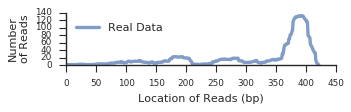

In [187]:
num_cols = 3
num_rows = 1

with dataviz.Figure(os.path.join(img_dir, "clipper_smoothing_raw.svg"), figsize=(1.5 * num_cols, 1.5 * num_rows)) as fig:

    ax= fig.add_subplot(1,1,1)
    ax.plot(data, alpha=.7, linewidth=3, label="Real Data")
    #ax.plot(spline_values, alpha=.7, linewidth=3, label="Smoothed Data")
    ax.set_ylim(0,)
    ax.legend(fontsize=10, loc=0)
    sns.despine(ax=ax)
    ax.set_ylabel("Number\nof Reads", fontsize=10)
    ax.set_xlabel("Location of Reads (bp)", fontsize=10)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

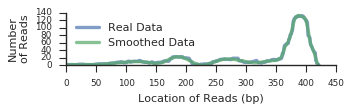

In [188]:
num_cols = 3
num_rows = 1

with dataviz.Figure(os.path.join(img_dir, "clipper_smoothing.svg"), figsize=(1.5 * num_cols, 1.5 * num_rows)) as fig:

    ax= fig.add_subplot(1,1,1)
    ax.plot(data, alpha=.7, linewidth=3, label="Real Data")
    ax.plot(spline_values, alpha=.7, linewidth=3, label="Smoothed Data")
    ax.set_ylim(0,)
    ax.legend(fontsize=10, loc=0)
    sns.despine(ax=ax)
    ax.set_ylabel("Number\nof Reads", fontsize=10)
    ax.set_xlabel("Location of Reads (bp)", fontsize=10)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]


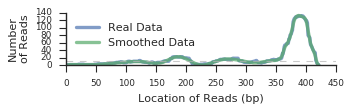

In [195]:
with dataviz.Figure(os.path.join(img_dir, "clipper_smoothing_with_cutoff.svg"), figsize=(1.5 * num_cols, 1.5 * num_rows)) as fig:

    ax= fig.add_subplot(1,1,1)
    ax.plot(data, alpha=.7, linewidth=3, label="Real Data")
    ax.plot(spline_values, linewidth=3, alpha=.7, label="Smoothed Data")
    ax.set_ylim(0,)
    sns.despine(ax=ax)
    ax.set_ylabel("Number\nof Reads", fontsize=10)
    ax.set_xlabel("Location of Reads (bp)", fontsize=10)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.axhline(threshold, alpha=.7, linewidth=1, linestyle="dashed", color=".7")
    ax.legend(loc=0)


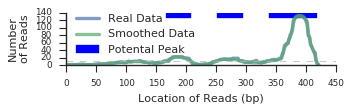

In [192]:
with dataviz.Figure(os.path.join(img_dir, "clipper_smoothing_with_cutoff_peaks.svg"), figsize=(1.5 * num_cols, 1.5 * num_rows)) as fig:

    ax= fig.add_subplot(1,1,1)
    ax.plot(data, alpha=.7, linewidth=3, label="Real Data")
    ax.plot(spline_values, linewidth=3, alpha=.7, label="Smoothed Data")
    ax.set_ylim(0,)
    sns.despine(ax=ax)
    ax.set_ylabel("Number\nof Reads", fontsize=10)
    ax.set_xlabel("Location of Reads (bp)", fontsize=10)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.axhline(threshold, alpha=.7, linewidth=1, linestyle="dashed", color=".7")
    
    for x, (start, stop, middle) in enumerate(peak_definitions):
        if x == 0:
            label="Potental Peak"
        else: 
            label = ""
        ax.axvspan(start, stop, ymin=.90, label=label, color='b')
    ax.legend(fontsize=10, loc=0)


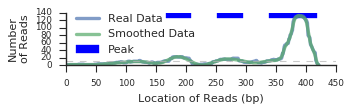

In [193]:
with dataviz.Figure(os.path.join(img_dir, "clipper_smoothing_with_cutoff_peaks_final.svg"), figsize=(1.5 * num_cols, 1.5 * num_rows)) as fig:

    ax= fig.add_subplot(1,1,1)
    ax.plot(data, alpha=.7, linewidth=3, label="Real Data")
    ax.plot(spline_values, linewidth=3, alpha=.7, label="Smoothed Data")
    ax.set_ylim(0,)
    sns.despine(ax=ax)
    ax.set_ylabel("Number\nof Reads", fontsize=10)
    ax.set_xlabel("Location of Reads (bp)", fontsize=10)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]
    ax.axhline(threshold, alpha=.7, linewidth=1, linestyle="dashed", color=".7")
    
    for x, (start, stop, middle) in enumerate(peak_definitions):
        if x == 0:
            label="Peak"
        else: 
            label = ""
        ax.axvspan(start, stop, ymin=.90, label=label, color='b')
    ax.legend(fontsize=10, loc=0)
